In [120]:
# 验证路径设置
%matplotlib inline
import os
import sys
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display
import query_to_wechat


# 自动计算项目根目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, "..", ".."))  
if project_root not in sys.path:
    sys.path.insert(0, project_root)

    
# 打印当前环境路径
print(f"Python executable: {sys.executable}")
print(f"Project root: {project_root}")
# 导入模块

try:
    from config.tickers import NASDAQ_100
    from config.NASDAQ_100_Chinese  import NASDAQ_100_Chinese
    from importnb import Notebook
    from openai import OpenAI 
    from dotenv import load_dotenv
    from IPython import get_ipython
    load_dotenv()  # 自动加载.env文件
    with Notebook():
        from src.visualization import plot_technical
        from src.downloader import download_stock_data
    print("✅ 模块导入成功！")
except ImportError as e:
    print(f"❌ 导入失败: {str(e)}")
    print("当前 Python 路径：", sys.path)


Python executable: c:\Users\PC\Documents\GitHub\stock_project\.venv\Scripts\python.exe
Project root: c:\Users\PC\Documents\GitHub\stock_project
✅ 模块导入成功！


In [121]:
# 下载股票数据
start_date = '2025-10-01'
end_date = '2025-12-31'
period = '3mo'
interval = '1h'
ticker = ['RIVN']

df = download_stock_data( ticker , start_date , end_date , period=period, interval=interval)
df.head()

Failed to get ticker 'RIVN' reason: Failed to perform, curl: (56) BoringSSL SSL_read: BoringSSL: error:100003fc:SSL routines:OPENSSL_internal:SSLV3_ALERT_BAD_RECORD_MAC, errno 0. See https://curl.se/libcurl/c/libcurl-errors.html first for more details.
[*********************100%***********************]  1 of 1 completed
c:\Users\PC\Documents\GitHub\stock_project\src\downloader.ipynb:61: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'] = df['Volume'].replace(0, np.nan).fillna(method='ffill')  # 处理成交量为0的情况


,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MACD,Bollinger_High,Bollinger_Low,VWAP,ADX,Volume Profile
Datetime,,,,,,,,,,,,,,,,,,
2025-08-13 13:30:00+00:00,12.0000,12.16,11.9050,12.1250,4878399.0,NaN,NaN,2.141958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.063333,0.0,4878399.0
2025-08-13 14:30:00+00:00,12.1250,12.15,12.0500,12.0950,4236312.0,-0.247420,-0.002477,0.829871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.079600,0.0,642087.0
2025-08-13 15:30:00+00:00,12.0950,12.12,12.0100,12.0601,2123417.0,-0.288554,-0.002890,0.915901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.076533,0.0,-1481330.0
2025-08-13 16:30:00+00:00,12.0675,12.12,12.0277,12.0450,1915082.0,-0.125202,-0.001253,0.767391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.074742,0.0,-3396412.0
2025-08-13 17:30:00+00:00,12.0500,12.11,11.9900,12.0944,1836122.0,0.410131,0.004093,1.000833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.073524,0.0,-1560290.0


c:\Users\PC\Documents\GitHub\stock_project\src\visualization.ipynb:213: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad = 0.1)


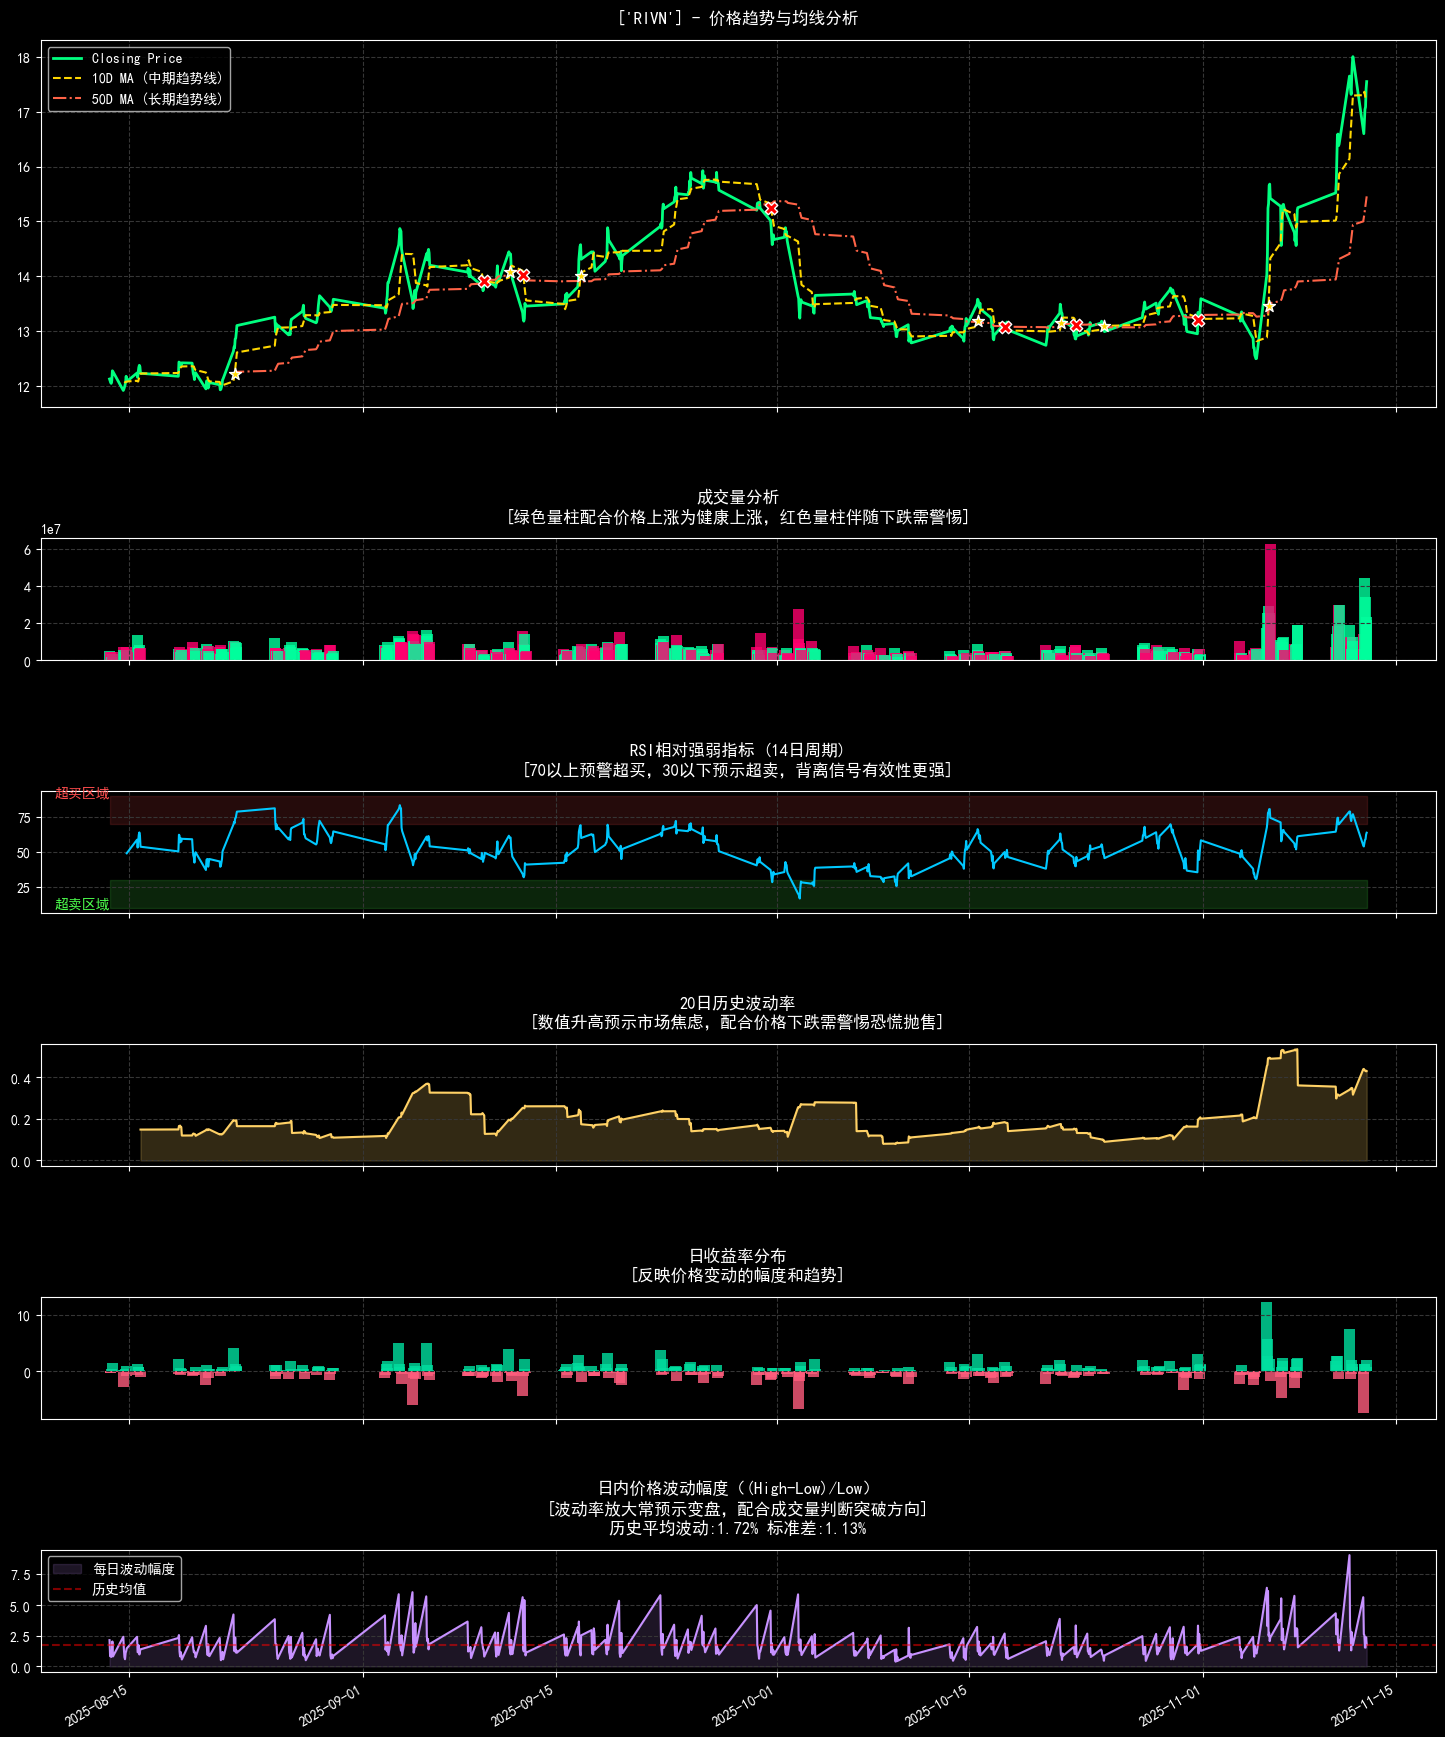

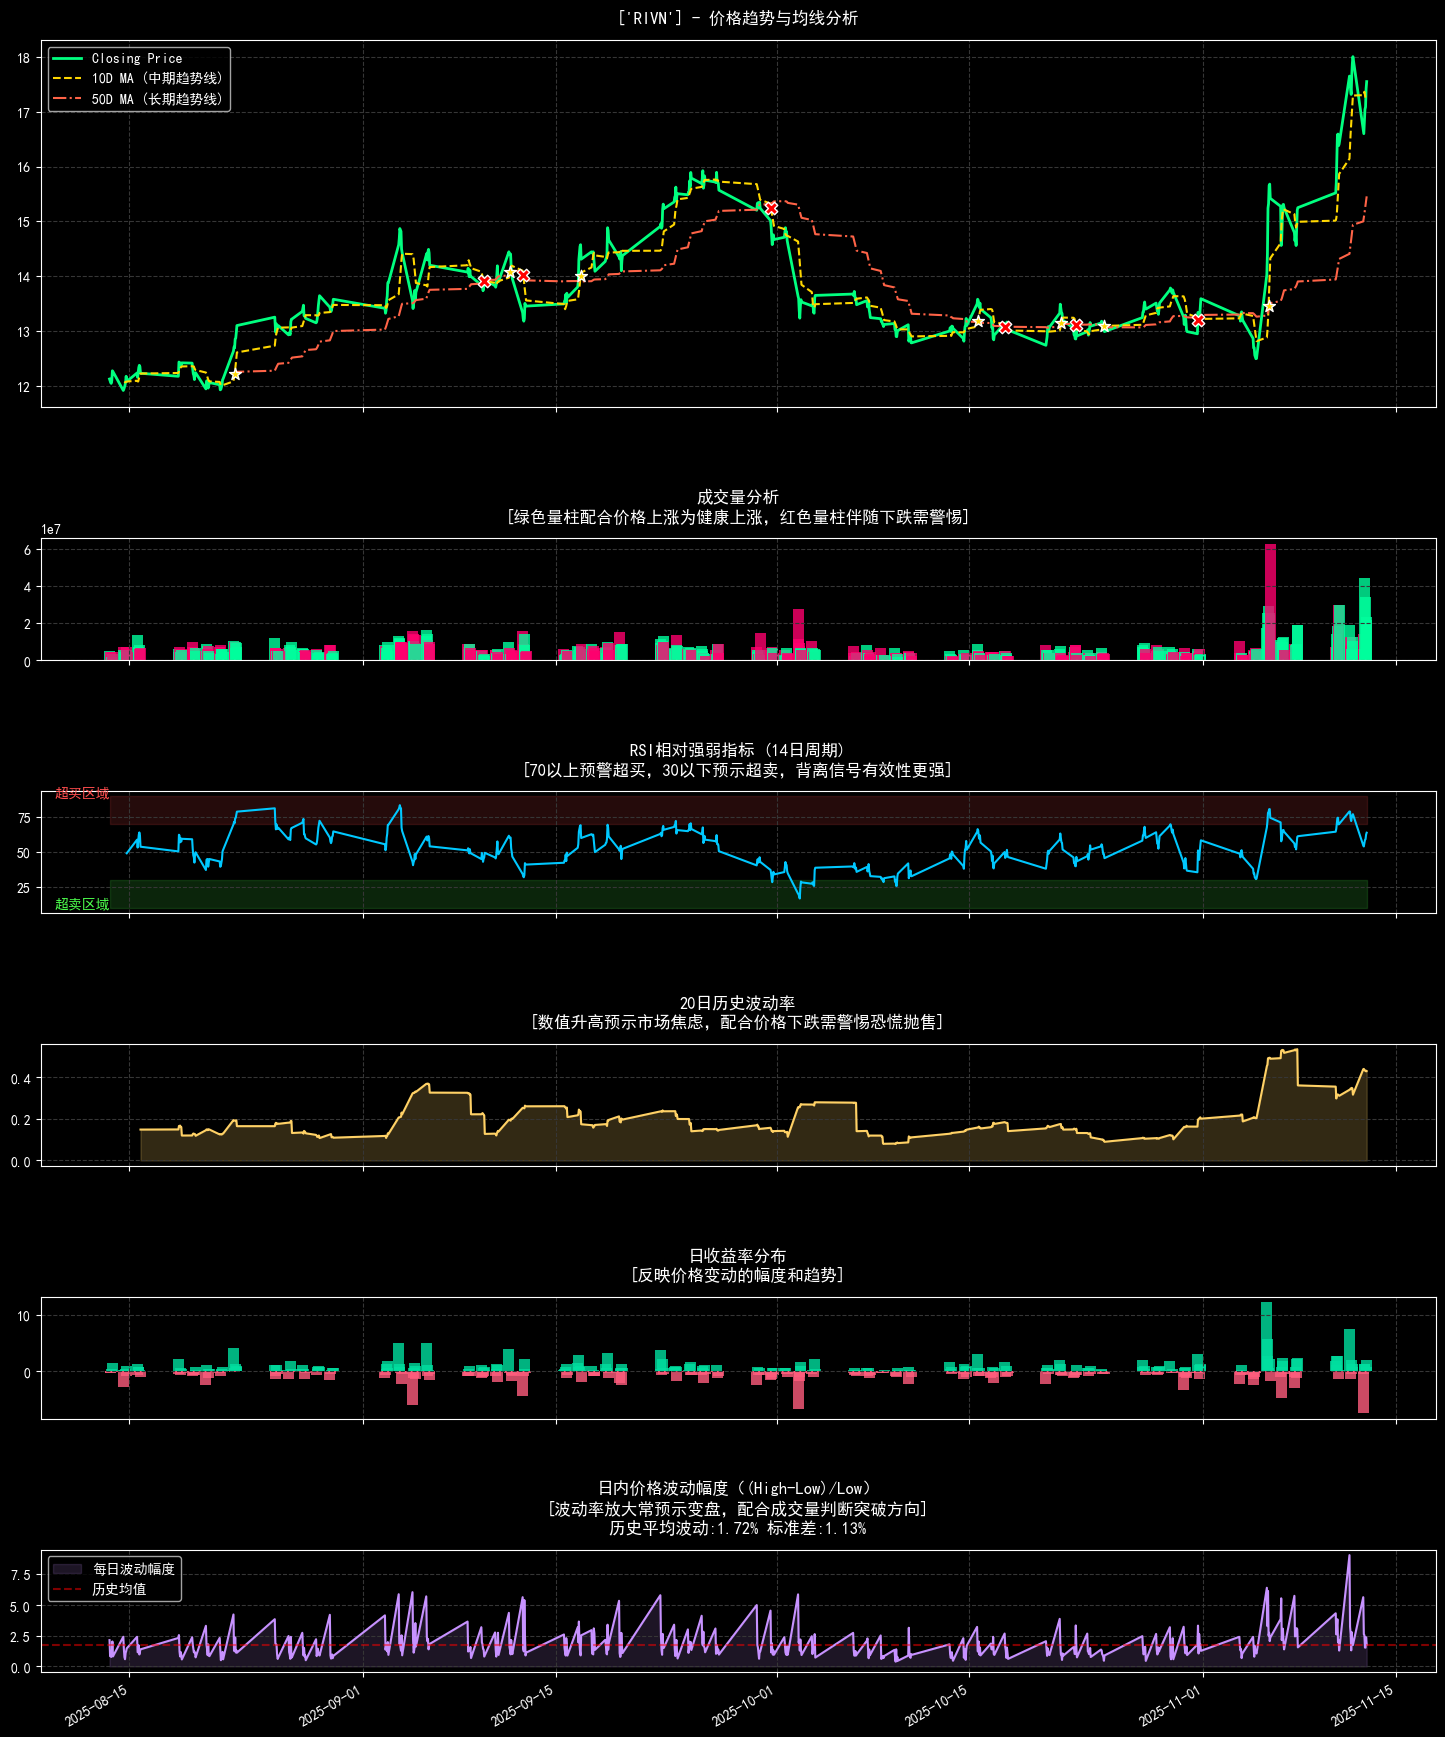

In [122]:
plot_technical(df,ticker)

In [ ]:
def get_deepseek_analysis(df, model="deepseek-r1-250120"):
    """
    智能生成股票技术面分析报告和预测未来趋势
    输入：预处理后的美股数据
    输出：deepseek的回答，不包含思考过程
    """
    
    from dotenv import load_dotenv
    load_dotenv()
    # 1、股票数据
    latest = df
        # 提取元数据
    start_date = df.index.min()
    end_date = df.index.max()

    # 生成数据摘要
    data_summary = f"""
    收盘价范围：${df['Close'].min():.2f} - ${df['Close'].max():.2f}
    平均成交量：{df['Volume'].mean():,.0f} 手
    近期波动率：{df['Close'].pct_change().std():.2%}（过去20日）
    """
    
    # 步骤2：构建专业分析提示词
    analysis_prompt = f"""你是美股投资专家，这是{ticker}从{start_date}到{end_date}的交易数据，
    请用简单专业的语言分析{ticker[0]}的走势及其多/空投资机会（请在操作建议时，附上信心指数，<20不建议操作；20-40观望；40-60可以清仓，及时止损；60-80可以开始逐步建仓；>80强烈信号，或可以立即操作）：
    {latest}
    如果你认为提供更多技术指标会有帮助，请告诉我有哪些，我会补充。
    """
    
    # 步骤3：调用Deepseek API并解析结果
    # try:
    notebook_path = get_ipython().config["IPKernelApp"]["connection_file"].split("\\")[-2]
    project_root = Path(notebook_path).resolve().parent.parent# 动态构建项目路径 
    client = OpenAI(
            api_key='sk-svlwkvpmiesxltcrmogahgwdpsucauiqdvdrgssmogbtujvh',
            base_url='https://api.siliconflow.cn/v1'
            )
    
    completion = client.chat.completions.create(
        model="deepseek-ai/DeepSeek-R1",
        messages=[
            {"role": "user", "content": analysis_prompt}
        ],
        max_tokens = 8192,
        temperature = 0.3
    )
    # 解析响应
    response_message = completion.choices[0].message

    # 提取回答和思考内容
    answer = response_message.content
    reasoning = response_message.reasoning_content

    # 格式化输出，只显示回答，不显示思考
    formatted_output = f'{answer.strip()}'

    output_file = "temp_output.md"
    with open(output_file, "w", encoding="utf-8") as f:
        f.write("# DeepSeek 分析报告\n\n")
        f.write("## 数据摘要\n")
        f.write(data_summary + "\n\n")
        f.write("## 分析结果\n")
        f.write(formatted_output + "\n")
    os.system(f'code {output_file}')  # 在默认Markdown查看器中打开文件
    
    return print(data_summary + "\n" + formatted_output)
        
    # except Exception as e:
    #     print(f"模型调用失败: {str(e)}")
    #     return "暂无分析结果"

In [124]:
message = get_deepseek_analysis(df)
print(message)
query_to_wechat.send_with_retry(title=message)


    收盘价范围：$11.92 - $18.00
    平均成交量：6,682,164 手
    近期波动率：1.44%（过去20日）
    
### RIVN走势分析及投资机会（2025-08-13 至 2025-11-12）

作为美股投资专家，我已分析RIVN（Rivian Automotive）提供的交易数据（时间范围：2025-08-13 13:30 UTC 至 2025-11-12 20:30 UTC，共455个数据点，每小时频率）。数据包括价格（开盘、最高、最低、收盘）、成交量及关键技术指标（如MA10、MA50、RSI、MACD、布林带、ADX、VWAP等）。以下是我的专业分析，基于趋势识别、技术指标和量价关系。分析采用简单、客观的语言，并严格遵循您要求的信心指数标准（<20不建议操作；20-40观望；40-60可清仓止损；60-80可逐步建仓；>80强烈信号）。

#### 整体走势分析
- **价格趋势**：RIVN呈现强劲的上涨趋势。起始价（2025-08-13 13:30）为$12.00，收盘价（2025-11-12 20:30）为$17.55，累计涨幅约45.8%。期间价格波动逐步放大，但未出现显著反转信号。
  - **关键阶段**：
    - **初期（8月）**：价格在$12附近震荡，波动率较低（约0.4-0.5），成交量温和，显示盘整。
    - **中期（9-10月）**：价格突破$13后加速上行，MA10上穿MA50（金叉信号），确认上升趋势。
    - **后期（11月）**：价格冲高至$17.55，11月12日单日涨幅显著（例如，20:30收盘价较开盘涨0.75%），伴随成交量激增（如17:30成交量4450万股），表明买方主导。
- **技术指标一致性**：
  - **移动平均线**：MA10（17.27）持续高于MA50（15.46），且MA10_above_MA50为True，显示短期动能强于长期趋势（看涨信号）。
  - **RSI（相对强弱指数）**：结束点RSI为63.76，略高于中性值50，但未达超买区（70+），表明上涨有空间但需警惕回调。
  - **MACD**：结束点MACD为0.5214，柱状图正值且稳定（无背离），暗示上涨动量持续。
  - **布林带**：价格（$17.55）位于

{'message': '[INPUT]title 不能为空',
 'code': 20001,
 'info': 'title 不能为空',
 'args': [None],
 'scode': 460}

In [125]:
df.head()

,Open,High,Low,Close,Volume,Daily Return,Log Return,Range Pct,MA10,MA50,Volatility,RSI,MACD,Bollinger_High,Bollinger_Low,VWAP,ADX,Volume Profile,MA10_above_MA50
Datetime,,,,,,,,,,,,,,,,,,,
2025-08-13 13:30:00+00:00,12.0000,12.16,11.9050,12.1250,4878399.0,NaN,NaN,2.141958,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.063333,0.0,4878399.0,False
2025-08-13 14:30:00+00:00,12.1250,12.15,12.0500,12.0950,4236312.0,-0.247420,-0.002477,0.829871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.079600,0.0,642087.0,False
2025-08-13 15:30:00+00:00,12.0950,12.12,12.0100,12.0601,2123417.0,-0.288554,-0.002890,0.915901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.076533,0.0,-1481330.0,False
2025-08-13 16:30:00+00:00,12.0675,12.12,12.0277,12.0450,1915082.0,-0.125202,-0.001253,0.767391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.074742,0.0,-3396412.0,False
2025-08-13 17:30:00+00:00,12.0500,12.11,11.9900,12.0944,1836122.0,0.410131,0.004093,1.000833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.073524,0.0,-1560290.0,False


In [126]:
def generate_report(ticker,start_date,end_date, period=None):
    import matplotlib.pyplot as plt
    
    df = download_stock_data([ticker], start_date, end_date, period)
    analysis_text = get_deepseek_analysis(df)
    fig = plot_technical(df,ticker)
    
    return plt.show(fig) ,analysis_text


In [127]:
generate_report(ticker,start_date,end_date, period=period)

TypeError: expected string or bytes-like object, got 'list'